# Investigating using Hitting Probabilities to detect if a Markov chain 'shoots off to infinity'

If the infinite Markov chain has a chance of never reaching the absorbing state, because there is a nonzero probability for the state to go off to infinity, then the truncated Markov chain will never be a good model. The truncated Markov chain will therefore be guaranteed to reach the boundary. Can we use the hitting probabilities to show this?

Consider the modified M/M/1 matrix, where $\Lambda < \mu$, so it does'nt shoot off to infinity:

In [1]:
import trunc

In [2]:
bound = 35
mm1_rate_matrix = trunc.make_modified_mm1_matrix(7, 9, 1, bound)
mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
trunc.find_hitting_probs(mm1_matrix, range(bound+1), bound-1)

This is visually different from the case when the Markov chain does shoot off to inifnity (when $\Lambda > \mu$)

In [3]:
bound = 35
mm1_rate_matrix = trunc.make_modified_mm1_matrix(9, 7, 1, bound)
mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
trunc.find_hitting_probs(mm1_matrix, range(bound+1), bound-1)

{0: 0.6667099084597568,
 1: 0.7407887871775075,
 2: 0.7984056928468691,
 3: 0.843218841700817,
 4: 0.8780735130316653,
 5: 0.9051827018445473,
 6: 0.9262676264767887,
 7: 0.9426670123018654,
 8: 0.955422090165814,
 9: 0.9653427062822186,
 10: 0.9730587410394224,
 11: 0.9790601014061363,
 12: 0.9837278261358027,
 13: 0.987358278703321,
 14: 0.990181964033613,
 15: 0.9923781637349511,
 16: 0.994086319058214,
 17: 0.9954148843096406,
 18: 0.9964482128385281,
 19: 0.9972519128054407,
 20: 0.997877012779706,
 21: 0.998363201648579,
 22: 0.9987413485465914,
 23: 0.9990354628006007,
 24: 0.9992642183314969,
 25: 0.9994421392999718,
 26: 0.9995805222754525,
 27: 0.999688153478604,
 28: 0.9997718666366109,
 29: 0.9998369768706161,
 30: 0.9998876181637315,
 31: 0.9999270058361546,
 32: 0.9999576406924835,
 33: 0.9999814678029616,
 34: 1.0}

We'd like to investigate what 'visual differences' are there. Can we automate this detection? Is there one single number that will tell us if a Markov chain shoots off to infinity or not?

## Probabilties from empty

Can we just look at the $h_{0b} = \mathbb{P}(\text{Probabiltiy of hitting the boudnary from state 0})$? Does this give us an indication of whether the Markov chain shoots off to infinitit or not?

For the modified M/M/1 queue, let's fix the arrival rate, but vary the service rate, and plot $h_{0b}$:

In [4]:
def hitting_prob_modified_mm1(arrival, service, psi, bound, s):
    mm1_rate_matrix = trunc.make_modified_mm1_matrix(arrival, service, psi, bound)
    mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
    probs = trunc.find_hitting_probs(mm1_matrix, range(bound+1), bound-1)
    return probs[s]

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

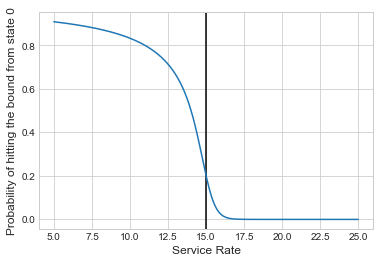

In [6]:
arr = 15
mus = np.linspace(arr-10, arr+10, 1000)
ps = [hitting_prob_modified_mm1(arr, mu, 1, 60, 0) for mu in mus]
plt.axvline(x=arr, c='black') # The line where $\Lambda = \mu$ (left of this line the MC shoots off to infinity, right of this line the MC stabalises)
plt.plot(mus, ps)
plt.xlabel('Service Rate', fontsize=12)
plt.ylabel('Probability of hitting the bound from state 0', fontsize=12)
plt.show()

There's something going on here...
Is the relationship reliant on the chosen bound?

[]

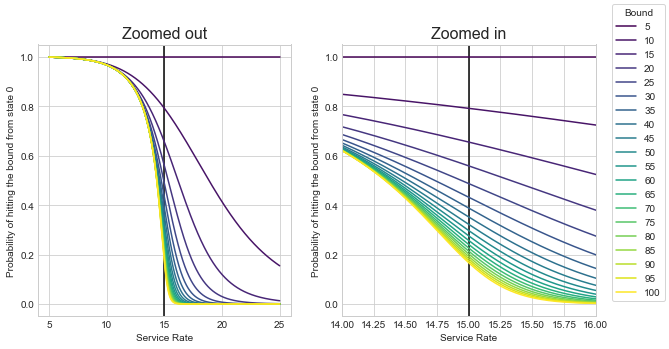

In [7]:
arr = 15
mus = np.linspace(arr-10, arr+10, 1000)
bounds = np.linspace(5, 100, 20)
ps = [[hitting_prob_modified_mm1(arr, mu, 1, int(b), 4) for mu in mus] for b in bounds]
colors = plt.cm.viridis(np.linspace(0, 1, len(bounds)))
i = 0
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].axvline(x=arr, c='black')
axarr[1].axvline(x=arr, c='black')
for b, p in zip(bounds, ps):
    axarr[0].plot(mus, p, c=colors[i], label=int(b))
    axarr[1].plot(mus, p, c=colors[i])
    i += 1
axarr[0].set_xlabel('Service Rate')
axarr[1].set_xlabel('Service Rate')
axarr[0].set_ylabel('Probability of hitting the bound from state 0')
axarr[1].set_ylabel('Probability of hitting the bound from state 0')
axarr[1].set_xlim(14, 16)
axarr[0].set_title('Zoomed out', fontsize=16)
axarr[1].set_title('Zoomed in', fontsize=16)
fig.legend(frameon=True, title='Bound')
plt.plot()

The relationship here is obvious, however there are two drawbacks:
+ The relationship is only obvious when 'zoomed out', that is, close the boundary where $\Lambda = \mu$ (as the Markov chain is about to change from stability to shooting off), the relationship isn't obvious.
+ The relationship relies on there being a large enough boundary. Therefore this is not a useful measure, as we don't know what 'large enough' means.

## Considering the 'rate' at which moving closer to the boundary increases $h_{sb}$

If $h_{0b}$ isn't a good measure, then what about the behaviour of $h_{sb}$ as $s$ approached the boundary?. Let's consider three cases:
 + $\Lambda < \mu$ (stabilises)
 + $\Lambda = \mu$ (shoots off)
 + $\Lambda > \mu$ (shoots off)

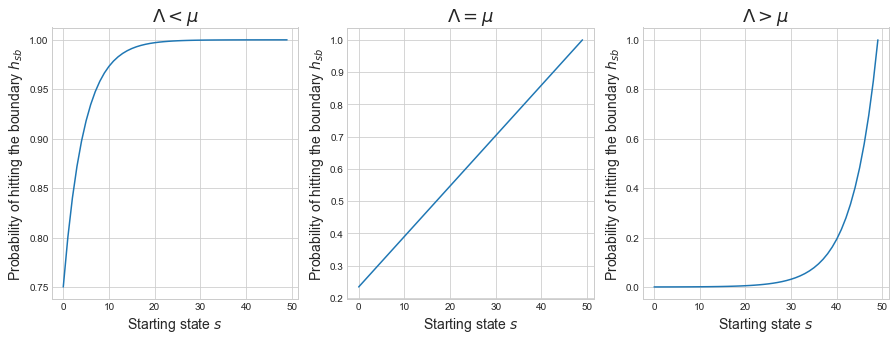

In [8]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
arr = 15
bound = 50
mus = [12, 15, 18]
sgn = ['<', '=', '>']
for i, m in enumerate(mus):
    mm1_rate_matrix = trunc.make_modified_mm1_matrix(arr, m, 1, bound)
    mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
    probs = trunc.find_hitting_probs(mm1_matrix, range(bound+1), bound-1)
    axarr[i].plot(probs.keys(), probs.values())
    axarr[i].set_xlabel('Starting state $s$', fontsize=14)
    axarr[i].set_ylabel('Probability of hitting the boundary $h_{sb}$', fontsize=14)
    axarr[i].set_title(f'$\Lambda {sgn[i]} \mu$', fontsize=18)

It seems that Markov chains that 'shoot off' have either linear or convex relationships between $s$ and $h_{sb}$, while Markov chains that stabilise have a concave relationship.

Does this also rely on the bound? Let's choose a very small bound and find out:

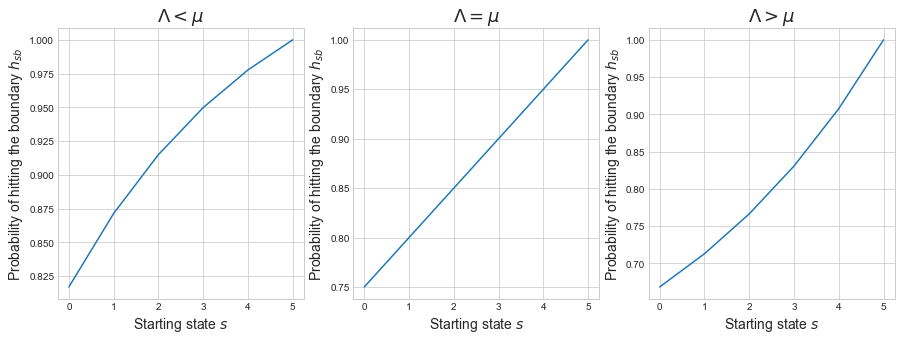

In [9]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
arr = 15
bound = 6
mus = [12, 15, 18]
sgn = ['<', '=', '>']
for i, m in enumerate(mus):
    mm1_rate_matrix = trunc.make_modified_mm1_matrix(arr, m, 1, bound)
    mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
    probs = trunc.find_hitting_probs(mm1_matrix, range(bound+1), bound-1)
    axarr[i].plot(probs.keys(), probs.values())
    axarr[i].set_xlabel('Starting state $s$', fontsize=14)
    axarr[i].set_ylabel('Probability of hitting the boundary $h_{sb}$', fontsize=14)
    axarr[i].set_title(f'$\Lambda {sgn[i]} \mu$', fontsize=18)

It still looks like it holds! Let's investigate with many many more parameters:

In [10]:
import matplotlib as mpl

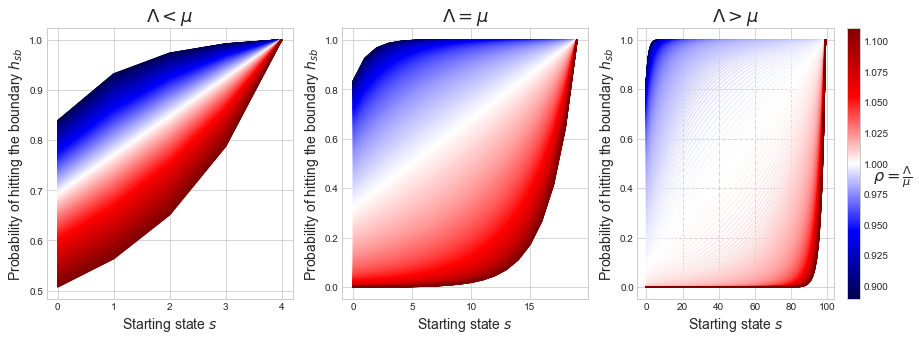

In [11]:
arr = 9
mus = np.linspace(arr-5, arr+5, 500)
colors = plt.cm.seismic(np.linspace(0, 1, len(mus)))
bounds = [5, 20, 100]
probs = []
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
for i, bound in enumerate(bounds):
    for j, m in enumerate(mus):
        mm1_rate_matrix = trunc.make_modified_mm1_matrix(arr, m, 1, bound)
        mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
        probs = trunc.find_hitting_probs(mm1_matrix, range(bound+1), bound-1)
        axarr[i].plot(probs.keys(), probs.values(), c=colors[j])
    axarr[i].set_xlabel('Starting state $s$', fontsize=14)
    axarr[i].set_ylabel('Probability of hitting the boundary $h_{sb}$', fontsize=14)
    axarr[i].set_title(f'$\Lambda {sgn[i]} \mu$', fontsize=18)
cbar = fig.colorbar(plt.cm.ScalarMappable(
    norm=mpl.colors.Normalize(vmin=(arr-1)/arr, vmax=(arr+1)/arr),
    cmap=plt.cm.seismic
))
cbar.set_label(r'$\rho = \frac{\Lambda}{\mu}$', fontsize=16, rotation=0)

We can think about this function as the 'acceleration' towards infinity:
  + If the closer we get to the boundary (a larger $s$) the rate at which the probability of reaching the boundary increases, then the MC 'accelerates' towards the boundary. That means the system 'accelerates' towards infinity, and shoots off. This is shown with a convex function.
  + If the closer we get to the boundary (a larger $s$) the rate at which the probability of reaching the boundary decreases, then the MC 'decelerates' towards the boundary. That means the system 'decelerates' towards infinity, and so doesn't shoots off, it stabilises. This is shown with a concave function.

### Can we measure concavity / convexity?

Idea 1: calculate the area between a straight line and the curve. If the area is negative then it's convex, if the area is positive then it's concave.

(This approach future-proofs us too, as we can apply this to multi-dimensional state spaces, with planes, and higher-dimensional linear objects...)

In [12]:
def find_area_between_curve_and_line(hitting_probs, bound):
    """
    Measure the area between the curve and a straight line.
    Convex ==> negative
    Concave ==> positive
    """
    p0 = hitting_probs[0]
    m = (1 - p0) / (bound - 1)
    line = [m*x + p0 for x in range(bound)]
    diffs = [l - hitting_probs[i] for i, l in enumerate(line)]
    return sum(diffs)

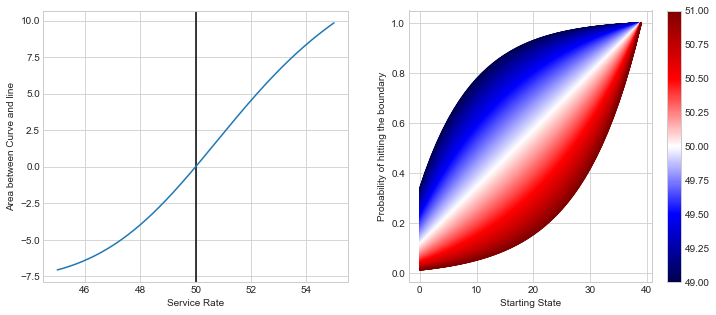

In [13]:
arr = 50
bound = 40
mus = np.linspace(arr-5, arr+5, 500)
colors = plt.cm.seismic(np.linspace(0, 1, len(mus)))
areas = []
fig, axarr = plt.subplots(1,2, figsize=(12, 5))
for i, mu in enumerate(mus):
    mm1_rate_matrix = trunc.make_modified_mm1_matrix(arr, mu, 10, bound)
    mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
    probs = trunc.find_hitting_probs(mm1_matrix, range(bound + 1), bound - 1)
    areas.append(find_area_between_curve_and_line(probs, bound))
    axarr[1].plot(probs.keys(), probs.values(), c=colors[i])
axarr[1].set_xlabel('Starting State')
axarr[1].set_ylabel("Probability of hitting the boundary")

axarr[0].axvline(x=arr, c='black')
axarr[0].plot(mus, areas)
axarr[0].set_xlabel('Service Rate')
axarr[0].set_ylabel('Area between Curve and line')

fig.colorbar(plt.cm.ScalarMappable(
    norm=mpl.colors.Normalize(vmin=arr-1, vmax=arr+1),
    cmap=plt.cm.seismic
))
plt.show()

We can see that if the area is negative then we have an unstable MC, but if it's positive we have a stable MC.

Is this reliant on the bound?

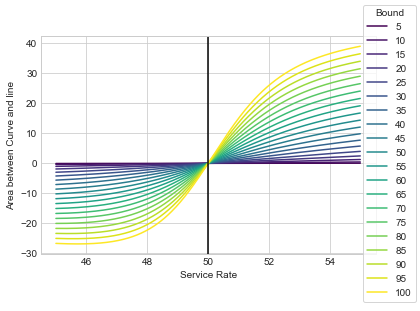

In [14]:
arr = 50
bounds = np.linspace(5, 100, 20)
mus = np.linspace(arr-5, arr+5, 500)
colors = plt.cm.viridis(np.linspace(0, 1, len(bounds)))

fig, ax = plt.subplots(1)
for j, b in enumerate(bounds):
    areas = []
    for i, mu in enumerate(mus):
        mm1_rate_matrix = trunc.make_modified_mm1_matrix(arr, mu, 10, int(b))
        mm1_matrix = trunc.discretise_transition_rate_matrix(mm1_rate_matrix)
        probs = trunc.find_hitting_probs(mm1_matrix, range(int(b) + 1), int(b) - 1)
        areas.append(find_area_between_curve_and_line(probs, int(b)))
    ax.plot(mus, areas, c=colors[j], label=int(b))

ax.axvline(x=arr, c='black')
ax.set_xlabel('Service Rate')
ax.set_ylabel('Area between Curve and line')
fig.legend(frameon=True, title='Bound')
plt.show()

Yes it looks like it isn't dependent on the bound!